<h1 align="center"> Image Captioning </h1>

Итак, мы сейчас займемся image captioning =)
![img](https://i.imgur.com/obITaMl.png)

## Описание

Image captioning -- это когда мы подаем модели каритнку, а она возвращает нам текст с описанием того, что на ней изображено. 

Как мы знаем из нашего замечательного курса, с картинками лучше всегоработают модели CNN, а с текстом -- RNN. Поэтому логично, что для image captioning нужно совместить и то, и другое =)

Для удобства (и, в какой-то степени, экономии времени), мы будем строить не одну большую модель CNN+RNN, которая будет кушать картинку и выдавать текст, а разобьем ее на две. Первая модель будет кушать картинку и выдавать вектор картинки, а вторая модель будет кушать этот вектор и генерировать текст. Вектор, по сути, будет числовым "описанием" картинки, в котором будет содержаться вся необходимая информация для второй сети, чтобы та смогла нагенерить текста с описанием. Короче, как в автоэнкодерах)

## План

Итак, как мы будем действовать:

Датасет: MSCOCO: [описание](http://cocodataset.org/#download), [ссылка для скачивания](https://yadi.sk/d/HR_cHsJcbMpL-g)

### Базовая часть:
1. Скачаем датасет (векторы картинок и соответствующие описания) и предобработаем описания так, как мы любим. Ну, токенизация там (да, в 100500-ый раз, только теперь сами)
2. В качестве первой сети возьмем Inception-v3 и скачаем к ней предобученные веса (тренировать и генерировать веса -- это оч долго, поверьте мне). 
3. Напишем вторую сетку, которая будет брать векторы из Inception-v3 и генерить описания.
4. Обучим вторую сеть на MSCOCO

### Вариативная часть:
Что еще можно сделать:
1. Нагуглить другой датасет (в MSCOCO видны паттерны -- все тексты выглядят как "хто-то с чем-то что-то делает")
2. Взять не Inseption-v3, а другую предобученную сеть
3. Запилить аттеншен во второй сети (не, ну а вдруг)
4. Написать бота ))0))
5. Whatever comes to your head

## Базовая часть:

### 1. Предобработка текстов из датасета

In [1]:
!pip3 install --upgrade nltk 

     |████████████████████████████████| 1.5MB 2.8MB/s 
  Created wheel for nltk: filename=nltk-3.4.5-cp36-none-any.whl size=1449908 sha256=d3fa0fb625670bbc10d6429d5b00b4da8a51f335566f2ac7c12baee1156530b6
  Stored in directory: /root/.cache/pip/wheels/96/86/f6/68ab24c23f207c0077381a5e3904b2815136b879538a24b483
Successfully built nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [2]:
!pip install scipy==0.19.1

     |████████████████████████████████| 48.2MB 61kB/s 
ERROR: yellowbrick 0.9.1 has requirement scipy>=1.0.0, but you'll have scipy 0.19.1 which is incompatible.
ERROR: seaborn 0.10.0 has requirement scipy>=1.0.1, but you'll have scipy 0.19.1 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 0.19.1 which is incompatible.
ERROR: mir-eval 0.5 has requirement scipy>=1.0.0, but you'll have scipy 0.19.1 which is incompatible.
ERROR: librosa 0.6.3 has requirement scipy>=1.0.0, but you'll have scipy 0.19.1 which is incompatible.
ERROR: cvxpy 1.0.25 has requirement scipy>=1.1.0, but you'll have scipy 0.19.1 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [3]:
import nltk
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all


       | 
       | Downloading package abc to /root/nltk_data...
       |   Unzipping corpora/abc.zip.
       | Downloading package alpino to /root/nltk_data...
       |   Unzipping corpora/alpino.zip.
       | Downloading package biocreative_ppi to /root/nltk_data...
       |   Unzipping corpora/biocreative_ppi.zip.
       | Downloading package brown to /root/nltk_data...
       |   Unzipping corpora/brown.zip.
       | Downloading package brown_tei to /root/nltk_data...
       |   Unzipping corpora/brown_tei.zip.
       | Downloading package cess_cat to /root/nltk_data...
       |   Unzipping corpora/cess_cat.zip.
       | Downloading package cess_esp to /root/nltk_data...
       |   Unzipping corpora/cess_esp.zip.
       | Downloading package chat80 to /root/nltk_data...
       |   Unzipping corpora/chat80.zip.
       | Downloading package city_database to /root/nltk_data...
       |   Unzipping corpora/city_database.zip.
       | Downloading package cmudict to /root/nltk_data...
  


---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [4]:
DATA_PATH = ''
%matplotlib inline

# For Google Colab only:
import sys
sys.path.append('/content/gdrive/My Drive/DL_school_project')
#from reco_utils.recommender.sar.sar_singlenode import SARSingleNode
from google.colab import drive
drive.mount('/content/gdrive')

DATA_PATH = '/content/gdrive/My Drive/DL_school_project/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
import json

# загружаем датасет
img_codes = np.load(DATA_PATH+"data/image_codes.npy")
captions = json.load(open(DATA_PATH+'data/captions_tokenized.json'))

In [6]:
# посмотрим на датасет
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[1,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[2]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.18828453 0.4872992  0.11505846 0.14832237 0.1037069  0.29469606
 0.13115333 0.34437215 0.29212648 0.05156532]

For each image there are 5 reference captions, e.g.:

the black and white dog stands near a person holding a frisbee .
a dog is looking at a blue frisbee .
a dog watches a person who is holding a frisbee .
a dog looking at a man holding a frisbee with another dog laying down .
a couple of dogs that are in a grassy field


In [7]:
#plt.imshow(img_codes[0])
img_codes.shape

(118287, 2048)

Как можно видеть, в датасете все captions (тексты-описания) уже токенизированы и приведены в нижний регистр. Нам осталось сделать следующее:

1. Добавить ко всем описаниям символы начала и конца предложения 
2. Посчитать частоту встречания каждого слова из словаря и оставить тольео те, которые встречаются больше Х раз (например, Х=5)
3. Создать словарь из оставшихся слов + символов начала, конца предложения и PAD символа
4. Написать функцию, которая будет возвращать батч из описаний. Мы такое уже делали на прошлвх занятиях. Батч должен выглядеть примерно так:

[[   1,  525, 8955, 5392, 9640, 4713, 7470,  525, 7341, 2296, 7696,2,    3,    3,    3,    3,    3,    3,    3],
   
[   1,  525, 8955, 6784, 3557,  525, 7341, 2296,    2,    3,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 9209, 3557, 5486, 8335, 3071, 2296,    2,    3,3,    3,    3,    3,    3,    3,    3,    3],

[   1, 6292, 1508, 8955, 9209, 6784, 3557, 3071, 6971, 5520, 7696,2,    3,    3,    3,    3,    3,    3,    3],

[   1,  525, 8955, 6784, 3557,  525, 7341, 6919, 2919, 6292,  250,393,  525, 4618, 8335, 6292, 7882, 7696,    2]]
         
То есть, короткие предложения дополняются PAD символами, слишком длинные обрезуются, в начале и конце по коду символа начал и конца предложения.

Уверена, эта часть вам покажется очень знакомой и легкой =)

In [0]:
import pandas as pd

words = [token for cap in captions for sent in cap for token in sent.split()]
word_num = pd.Series(nltk.FreqDist(words)).sort_values(ascending=False)

In [57]:
word_num[:20]

a           978125
.           444661
on          215537
of          203940
the         197668
in          183933
with        154705
and         140709
is           98138
man          72984
to           68106
sitting      52880
an           49848
two          48320
,            44448
at           42703
standing     42450
people       41895
are          41060
next         37196
dtype: int64

In [0]:
init_token = '<sos>'
eos_token = '<eos>'
unk_token = '<unk>'
pad_IDX = '<pad>'
vocab = ([init_token, eos_token, pad_IDX, unk_token]+list(word_num[word_num>=5].index))
int2word = dict(enumerate(vocab))
word2int = {ch: ii for ii, ch in int2word.items()}
encoded = np.array([word2int[ch] for ch in vocab])
n_tokens = len(vocab)

In [0]:
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sent = captions[img_i][caption_i] 
        captions[img_i][caption_i] = '<sos>'+' '+ sent+' '+ '<eos>'

In [12]:
pad_ID = word2int[pad_IDX]
init_ID = word2int[init_token]
eos_ID = word2int[eos_token]
unk_ID = word2int[unk_token]
n_tokens

10403

In [0]:
def get_batch_cap(cap, train = True):
  batch_captions = []
  
  if train:
    cap = [sent.split() for sent in cap]
  max_len = max(map(len,cap))
    
  for sent in cap:
    
    sent2int = [word2int.get(token, unk_ID) for token in sent]
    sent2int += [pad_ID]*(max_len - len(sent2int))
    batch_captions.append(sent2int)

  return np.array(batch_captions)


In [61]:
k = get_batch_cap(captions[185])
k

array([[   0,    4,   52,   82,   20,   23,   14,    4,   68,  118,    5,
           1,    2,    2,    2,    2],
       [   0,    4,   52,   82,    9,    4,  396, 1127,  454,    4,   68,
         118,    9,    4,  139,    1],
       [   0,    4,    3,   82,    9,    4, 1127,   12,  454,    4,  118,
           1,    2,    2,    2,    2],
       [   0,    4,   52,   82,  454,    4,  118,    9,    4,  539,    5,
           1,    2,    2,    2,    2],
       [   0,    4,   52,  977, 1122,    4,  118,  144,  382,    1,    2,
           2,    2,    2,    2,    2]])

### 2. Напишем свою сетку из RNN для вывода описаний


Сейчас мы напишем сеть, которая будет получать выходы CNN-сетки (эмбеддинги картинок) и преобразовывать их в текст.

In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
class CaptionNet(nn.Module):
  def __init__(self, n_tokens= n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048, dropout=0.1):
        super(self.__class__, self).__init__()
        
        # два линейных слоя, которые будут из векторов, полученных на выходе Inseption, 
        # получать начальные состояния h0 и c0 LSTM-ки, которую мы потом будем 
        # разворачивать во времени и генерить ею текст
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # вот теперь recurrent part

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.embedding = nn.Embedding(n_tokens, emb_size) 
        self.dropout = nn.Dropout(dropout)

        # lstm: настакайте LSTM-ок (1 или более, но не надо сразу пихать больше двух, замечаетесь ждать).
        self.rnn = nn.LSTM(emb_size, lstm_units, num_layers = 2, batch_first=True, dropout = dropout) #(lstm embd, hid, layers, dropout)
        
        # ну и линейный слой для получения логитов
        self.logits = nn.Linear(lstm_units, n_tokens) # Projection :hid_dim x output_dim


  def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor, содержаший выходы inseption. Те, из которых будем генерить текст
                shape: [batch, cnn_feature_size]
        :param captions_ix: 
                таргет описания картинок в виде матрицы
        :returns: логиты для сгенерированного текста описания, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        initial_cell = torch.cat((initial_cell.unsqueeze(0),initial_cell.unsqueeze(0)),0)
        initial_hid = torch.cat((initial_hid.unsqueeze(0),initial_hid.unsqueeze(0)),0)
        
        #captions_ix = captions_ix.unsqueeze(0) 
        #print(captions_ix.shape)
        captions_emb = self.embedding(captions_ix)# embd over input and dropout 
        captions_emb = self.dropout(captions_emb)
       
        # применим LSTM:
        # 1. инициализируем lstm state с помощью initial_* (сверху)
        # 2. скормим LSTM captions_emb
        # 3. посчитаем логиты из выхода LSTM
        lstm_out, (hidden, cell) = self.rnn(captions_emb, (initial_hid,initial_cell))  # shape: [batch, caption_length, lstm_units]
        
        logits = self.logits(lstm_out)
        
        return logits        

In [0]:
network = CaptionNet(n_tokens)
network = network.cuda()


In [0]:
optimizer = optim.Adam(network.parameters(), lr=0.001)


Поделим выборку на train/test:

In [0]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [0]:
# batch generator. Можно заменить на свой/переделать этот
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = get_batch_cap(batch_captions)
    #print(batch_captions_ix)
    
    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)
    

In [66]:
    generate_batch(img_codes,captions,5)

(tensor([[0.3543, 0.4702, 0.7905,  ..., 0.6767, 1.2275, 1.0184],
         [0.3691, 0.4656, 0.6723,  ..., 0.6034, 0.5099, 0.1783],
         [0.8895, 0.2210, 1.2052,  ..., 0.3972, 1.6245, 0.0892],
         [0.4384, 0.1433, 0.1540,  ..., 0.0399, 0.3948, 0.1784],
         [0.0525, 0.3212, 0.2134,  ..., 0.1549, 0.1758, 0.2822]]),
 tensor([[   0,    4,   25,   15,   19,    4,  101,   27, 1045,    6,    4,  238,
             7,  322,    5,    1],
         [   0,  185,   18,  478,   11,   54,    6,    4,  374,   10, 1396,    5,
             1,    2,    2,    2],
         [   0,    4,   47,   10,    4,  762,  133,  147,   10,  329,    7,  442,
             5,    1,    2,    2],
         [   0, 1011,  216,   20,    9,    4,   38,   11,  243,   10,  131,    9,
             8,  159,    1,    2],
         [   0,    4,   82,   10,   43,  809,    6,    8,  622,    7,    4,   92,
             1,    2,    2,    2]]))

In [24]:
# загружаем inseption
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth


In [0]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor c выходами inception. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor с описаниями (в виде матрицы). shape: [batch, word_i]. 
    
    :returns: scalar crossentropy loss (neg log likelihood) for next captions_ix given previous ones
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()

    #print(captions_ix_inp.shape)
    
    # apply the network, get predictions for captions_ix_next
    image_vectors = image_vectors.cuda()
    captions_ix_next = captions_ix_next.cuda()
    logits_for_next = network.forward(image_vectors, captions_ix_inp.cuda())
    logits_for_next = logits_for_next.transpose(1, 2) 
    
    
    # compute the loss function between logits_for_next and captions_ix_next
    # ВАЖНО: не забудтье, что PADDING не должен влиять на лосс -- лосс должен склыдваться
    # только из тех мест, где должно быть предсказано слово, а не PAD
    # это можно сделать либо заведя маску из нулей и единиц (captions_ix_next != pad_ix) и умножить на нее лосс,
    # либо просто используя ignore_index, который в торче есть как аргумент у некоторых лоссов.
    #print(captions_ix_next.shape)
    #print(logits_for_next.shape)
    loss = F.cross_entropy(logits_for_next, captions_ix_next, ignore_index = pad_ID).reshape(1)
    
    return loss

## Train it

Как обычно, пишем цикл тренировки, запоминаем лоссы для графиков и раз в Х такстов тренировки считаем val_loss. 

In [0]:
batch_size = 100  
n_epochs = 100
n_batches_per_epoch = 150  
n_validation_batches = 5 


In [72]:
#from tqdm import tqdm
history_train_loss = []
history_val_loss = []
for epoch in range(n_epochs):
    train_loss=0
    network.train(True)
    for _ in range(n_batches_per_epoch):
        
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
            
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        optimizer.zero_grad()
        loss_t.backward()
        #nn.utils.clip_grad_norm_(network.parameters(), 3)
        optimizer.step()
    
        
        train_loss += loss_t.item()
        
    train_loss /= n_batches_per_epoch
    history_train_loss.append(train_loss)

    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.item()
    val_loss /= n_validation_batches
    history_val_loss.append(val_loss)
    print('\nEpoch: {}, train Perplexity: {}, val Perplexity: {}'.format(epoch, np.exp(train_loss), np.exp(val_loss)))

print("Finished!")


Epoch: 0, train Perplexity: 186.1551615093397, val Perplexity: 115.47050628737118

Epoch: 1, train Perplexity: 81.10300251233704, val Perplexity: 63.61826409551078

Epoch: 2, train Perplexity: 50.3968645780727, val Perplexity: 49.70663474683553

Epoch: 3, train Perplexity: 38.317473861980446, val Perplexity: 33.3672504012858

Epoch: 4, train Perplexity: 32.15605197961754, val Perplexity: 28.874867842531646

Epoch: 5, train Perplexity: 27.79510185910475, val Perplexity: 25.942282251362506

Epoch: 6, train Perplexity: 25.380260053171938, val Perplexity: 23.283074466327857

Epoch: 7, train Perplexity: 23.588642042951506, val Perplexity: 21.16873299384739

Epoch: 8, train Perplexity: 21.93682652708414, val Perplexity: 21.407094206205578

Epoch: 9, train Perplexity: 20.9968736993913, val Perplexity: 20.1772926925933

Epoch: 10, train Perplexity: 19.64005464577898, val Perplexity: 19.468011787439973

Epoch: 11, train Perplexity: 19.175450173609438, val Perplexity: 18.808417772266335

Epoch:

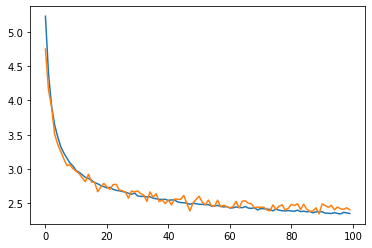

In [73]:
import matplotlib.pyplot as plt
plt.plot(history_train_loss)
plt.plot(history_val_loss)

## Inseption и получение результатов


### Сгенерируем описание

In [0]:
def generate_caption(image, caption_prefix= init_token, t=1, sample=True, max_len=15):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)
        
        vectors_8x8, vectors_neck, logits = inception(image[None])
        #print(vectors_neck.shape)
        caption_prefix = [caption_prefix]
        
        network.train(False)

        for _ in range(max_len):
            # представить в виде матрицы
            prefix_ix = get_batch_cap([caption_prefix], train=False)
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
            # получаем логиты из RNN-ки
            next_word_logits = network.forward(vectors_neck.cuda(), prefix_ix.cuda())[0, -1]
            #print(next_word_logits)
            # переводим их в вероятности
            next_word_probs = F.softmax(next_word_logits, dim=-1).cpu().data.numpy()
            #print( len(next_word_probs.shape))

            assert len(next_word_probs.shape) == 1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # опционально

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs)
                #print(next_word) 
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)
            
            # RNN-ка сгенерила символ конца предложения, расходимся
            #print(next_word)
            #print(eos_token)
            if next_word == eos_token:
                break
            
    return caption_prefix

### Скачаем пару картинок, чтобы проверить качество:

In [74]:
from matplotlib import pyplot as plt
from scipy.misc import imresize
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.


--2020-02-22 11:17:31--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.248.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.248.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107928 (105K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 105.40K  --.-KB/s    in 0.04s   

2020-02-22 11:17:31 (2.78 MB/s) - ‘img.jpg’ saved [107928/107928]



/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


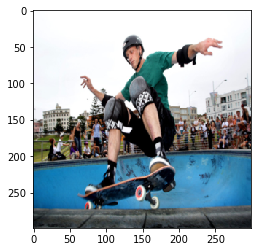

In [45]:
plt.imshow(img)

In [75]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.,)[1:-1]))

a man riding a skateboard down a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard down a ramp .
a man riding a skateboard down a ramp .


--2020-02-22 11:17:43--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 104.239.249.248
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2020-02-22 11:17:43--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 104.37K  --.-KB/s    in 0.04s   

2020-02-22 11:17:43 (2.87 MB/s) - ‘img.jpg’ saved [106870/106870]



/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


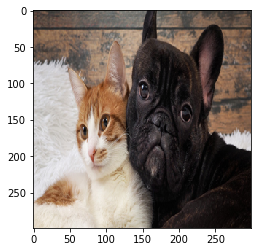

a dog is sitting on a couch with a remote control .
a dog is sitting on a couch with a remote control .
a dog is sitting in the grass next to a cat .
a dog is sitting on a couch with a remote control .
a dog is sitting on a couch with a remote control .
a dog is sitting on a couch with a remote control .
a dog with a collar on its head on a remote control .
a cat is sitting on a couch with a remote control .
a dog is sitting on a couch with a remote .
a dog is sitting on a couch with a remote .


In [76]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2020-02-22 11:18:17--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Chihuahua-With-Big-Pink-Tongue1-resized-150x150.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 104.239.249.248
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Chihuahua-With-Big-Pink-Tongue1-resized-150x150.jpg [following]
--2020-02-22 11:18:17--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Chihuahua-With-Big-Pink-Tongue1-resized-150x150.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|104.239.249.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5453 (5.3K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]   5.33K  --.-KB/s    in 0s      

2020-02-22 11:18:17 (304 MB/s) - ‘img.jpg’ saved [5453/5453]



/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


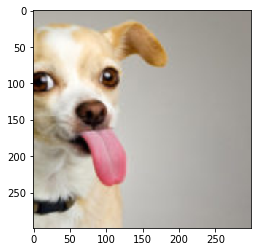

a dog is sitting on a couch with a dog .
a dog with a hat on a leash .
a dog is looking at the camera with a dog .
a dog is sitting in a chair with a red hat .
a dog is sitting on a couch with a dog .
a dog is sitting on a chair with a dog .
a dog is looking at a dog with a hat .
a dog is looking at a dog with a hat on .
a dog with a red hat and a hat .
a dog is sitting on a brown and white dog .


In [77]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Chihuahua-With-Big-Pink-Tongue1-resized-150x150.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo

ВОТ ЩАС БУИТ СМИШНО

Теперь ищите свои картинки, применяйте к ним сетку, смотрите че получится, реализовывайте вариативную часть =)

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


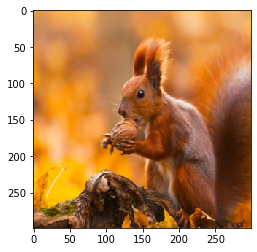

a woman holding a cat in her hand .
a woman holding a cat in her hand .
a woman holding a cat in her hand .
a woman holding a cat in her hand .
a woman is holding a cat in her hand .
a woman holding a cat in her hand .
a woman holding a cat in her hand .
a woman is playing with a large teddy bear .
a woman holding a cat in her hand .
a woman holding a cat in her hand .


In [78]:
img = plt.imread('/content/look.com.ua-112302.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


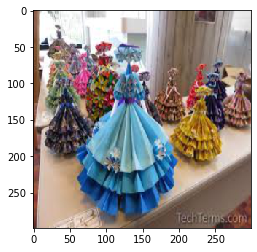

a white and blue train is sitting on a table .
a large vase with a bunch of flowers on it
a table topped with a table topped with flowers .
a table topped with a bunch of flowers .
a blue and white train sitting on a table .
a large vase filled with lots of flowers .
a white and blue vase with a vase of flowers .
a small vase with flowers in it
a white and blue train with a bunch of flowers in it .
a white table topped with a bunch of flowers .


In [79]:
img = plt.imread('/content/images.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/usr/local/lib/python3.6/dist-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


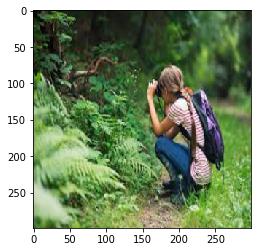

a woman is sitting on a bench with a dog .
a woman is sitting on a bench with a surfboard .
a woman is sitting on a bench with a dog .
a woman is sitting on a bench with a surfboard .
a woman is sitting on a bench with a dog .
a woman sitting on a bench with a dog .
a woman in a bikini holding a surfboard .
a woman is sitting on a bench in the grass .
a woman is sitting on a bench with a dog in the background .
a woman sitting on a bench with a dog .


In [80]:
img = plt.imread('/content/images_woman.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))